In [1]:
from tvb.simulator.lab import *
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as plc
import time as tm
from utils import *
import logging
logging.disable(logging.CRITICAL)
import warnings
warnings.filterwarnings("ignore")

In [2]:
# Data
data_path = '/Users/gpret/Desktop/MEDICINA/TVB_Distribution/demo_scripts/myScripts/For_OHBM/For_OHBM/tutorial_data'

In [3]:
con = connectivity.Connectivity.from_file(f'{data_path}/connectivity.vep.zip')
con.tract_lengths = np.zeros((con.tract_lengths.shape))             # no time-delays
con.weights[np.diag_indices(con.weights.shape[0])] = 0 #mette a zero i weights degli indici diagonali, che sono quelli di una
#area con se stessa
# con.weights = np.log(con.weights+1)
con.weights /= con.weights.max() # a /= b equivale a fare a = a/b
con.configure()
nb_regions = con.number_of_regions
roi = con.region_labels

In [4]:
roi

array(['Left-Frontal-pole', 'Left-Orbito-frontal-cortex',
       'Left-Gyrus-rectus', 'Left-F3-Pars-Orbitalis',
       'Left-F3-Pars-triangularis', 'Left-F3-pars-opercularis',
       'Left-Inferior-frontal-sulcus', 'Left-F2-rostral',
       'Left-F2-caudal', 'Left-Middle-frontal-sulcus', 'Left-SFS-rostral',
       'Left-SFS-caudal', 'Left-F1-mesial-prefrontal', 'Left-PreSMA',
       'Left-SMA', 'Left-F1-lateral-prefrontal',
       'Left-F1-lateral-premotor', 'Left-Subcallosal-area',
       'Left-Precentral-sulcus-inferior-part',
       'Left-Precentral-sulcus-superior-part',
       'Left-Precentral-gyrus-head-face',
       'Left-Precentral-gyrus-upper-limb',
       'Left-Central-sulcus-head-face', 'Left-Central-sulcus-upper-limb',
       'Left-Paracentral-lobule', 'Left-Central-operculum',
       'Left-Parietal-operculum', 'Left-Anterior-cingulate-cortex',
       'Left-Middle-cingulate-cortex-anterior-part',
       'Left-Middle-cingulate-cortex-posterior-part',
       'Left-Posterior-c

## First try without stimulation to check nothing spontanously seizes

In [5]:
# Here we set up the EZ node such that it is close to the critical working point, i.e. the seizure threshold
x0ez=-2.15
x0pz=-2.25
x0num=-2.5

#Here I set the x0 emulating a temporal sclerosis, which is worse in in the anterior right hippocampus but also made 
#damage to nearby areas, as showed in common MRI findings (https://radiopaedia.org/articles/1664)
EZ = ['Right-Hippocampus-anterior']
PZ = ['Right-Hippocampus-posterior', 'Right-Parahippocampal-cortex', 'Right-Rhinal-cortex', 'Right-Amygdala', 'Right-T3-anterior', 
      'Right-Posterior-cingulate-cortex-dorsal', 'Right-Posterior-cingulate-cortex-retrosplenial-gyrus']
idx_EZ = np.where(roi == EZ)
idx_PZ = [np.where(roi == pz) for pz in PZ]

epileptors = models.Epileptor(r=np.array([0.00035]))
epileptors.x0 = x0num*np.ones(nb_regions)
epileptors.x0[idx_EZ] = x0ez
for id in idx_PZ:
    epileptors.x0[id] = x0pz
    x0pz -= 0.02

# Coupling
coupl = coupling.Difference(a=np.array([-0.2]))

# Integrators
hiss = noise.Additive(nsig = np.array([0., 0., 0., 0.0003, 0.0003, 0.]))
heunint = integrators.HeunStochastic(dt=0.1, noise=hiss)

# Monitors
mons = [monitors.TemporalAverage(period=5.0)]

init_cond = np.array([-1.98742113e+00 , -1.87492138e+01, 4.0529597e+00, -1.05214059e+00, -4.95543740e-20, -1.98742113e-01])
print(init_cond)
init_cond_reshaped = np.repeat(init_cond, nb_regions).reshape((1, len(init_cond), nb_regions, 1))

# Simulator
sim = simulator.Simulator(model=epileptors,
                          initial_conditions=init_cond_reshaped,
                          connectivity=con,
                          coupling=coupl,
                          integrator=heunint,
                          monitors=mons)

sim.configure()

# Run
print("Starting simulation...")
tic = tm.time()
simulation_length = 5000
ttavg = sim.run(simulation_length=simulation_length)
print("Finished simulation.")
print('execute for ' + str(tm.time()-tic))

[-1.98742113e+00 -1.87492138e+01  4.05295970e+00 -1.05214059e+00
 -4.95543740e-20 -1.98742113e-01]
Starting simulation...
Finished simulation.
execute for 92.16316199302673


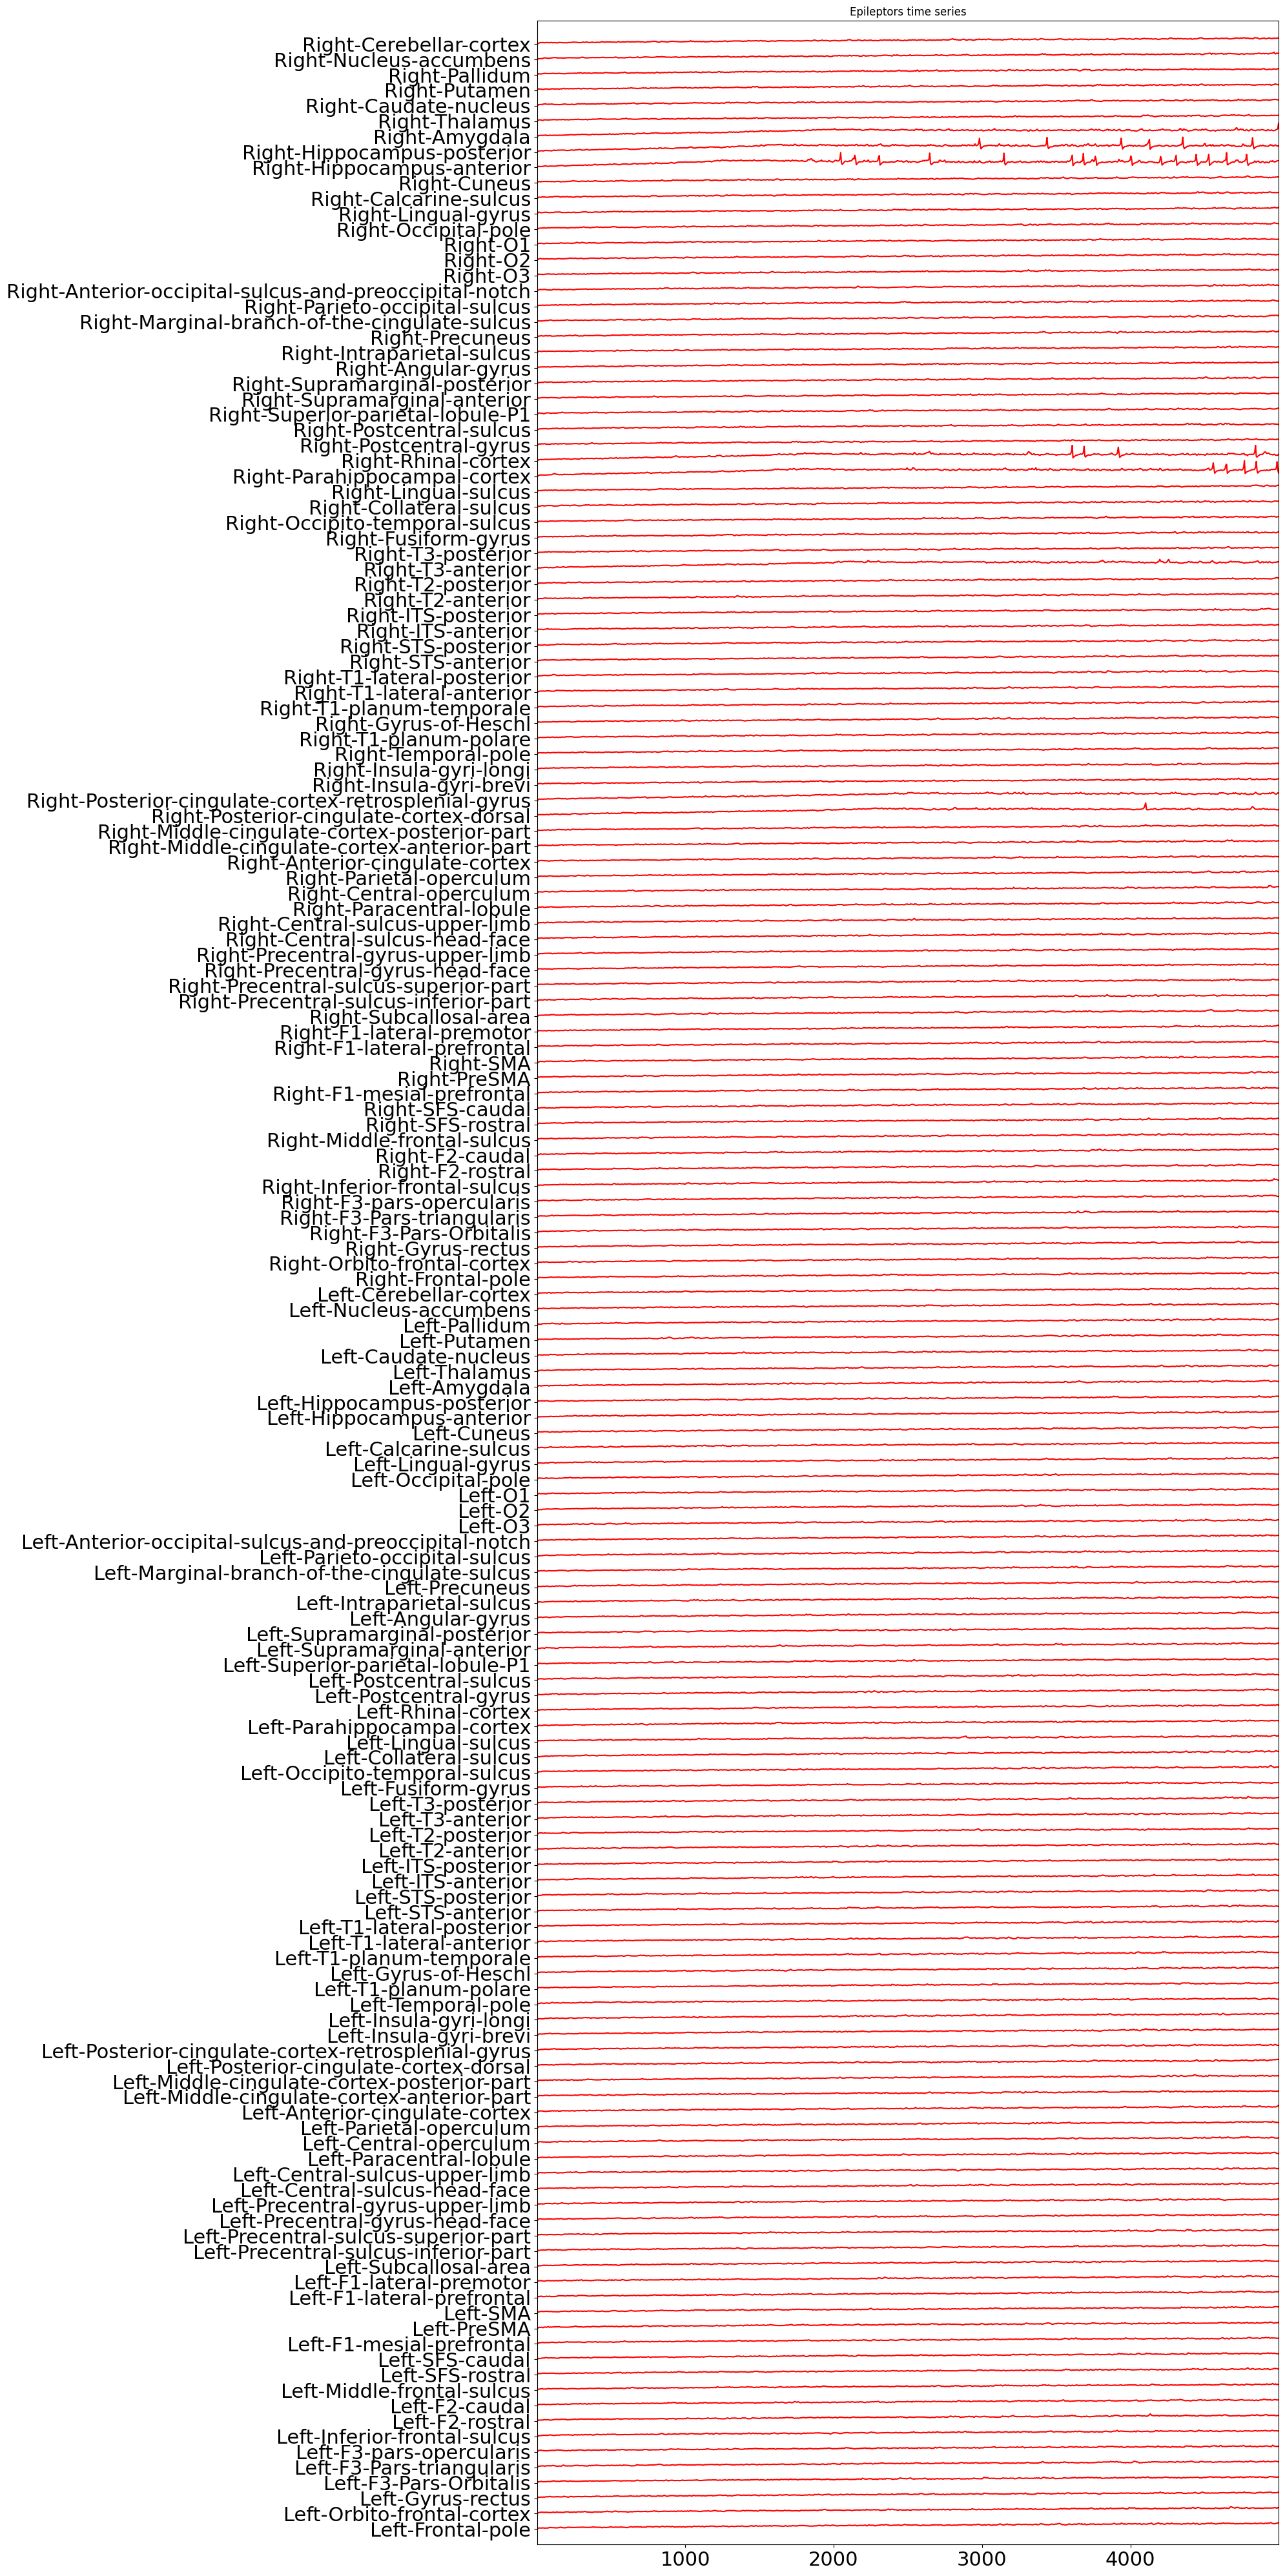

In [6]:
tts = ttavg[0][0]
tavg = ttavg[0][1]
srcSig = tavg[:,0,:,0]
start_idx = 0
end_idx = tavg.shape[0]

srcSig_normal=srcSig/np.ptp(srcSig)
#Plot raw time series
figure= plt.figure(figsize=(20,40))
plt.plot(tts[start_idx:end_idx], srcSig_normal[start_idx:end_idx] + np.r_[:162], 'r')
plt.title("Epileptors time series")
roi = con.region_labels
plt.yticks(np.arange(len(roi)),roi, fontsize=22)

# These should be set manually, since they depend on the model parameters
plt.xticks(fontsize=22)
plt.ylim([-1,len(roi)+0.5])
plt.xlim([tts[start_idx],tts[end_idx-1]])
plt.tight_layout()
plt.show()

In [7]:
idx_PZ

[(array([154], dtype=int64),),
 (array([133], dtype=int64),),
 (array([134], dtype=int64),),
 (array([155], dtype=int64),),
 (array([127], dtype=int64),),
 (array([111], dtype=int64),),
 (array([112], dtype=int64),)]

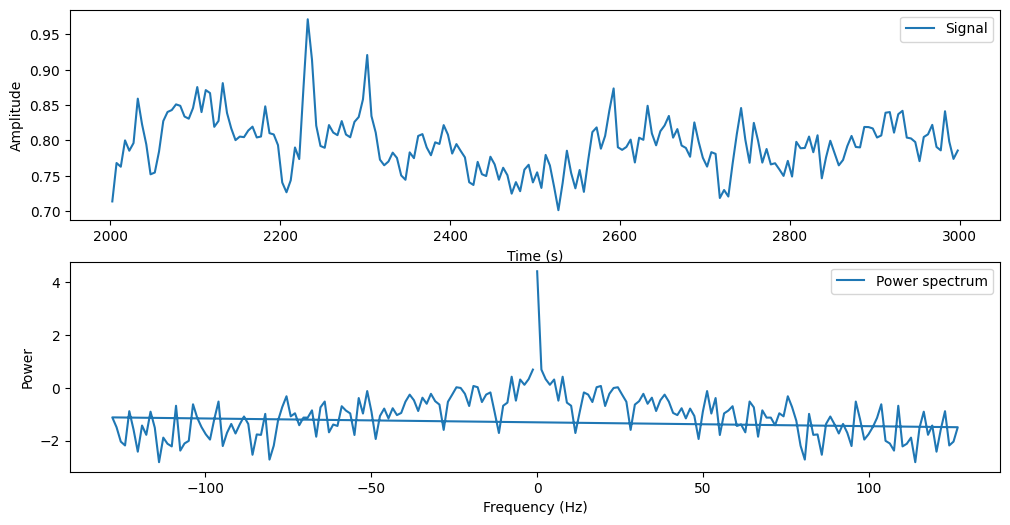

In [8]:
# Compute the FFT and the power spectrum
X = np.fft.fft(srcSig[400:600,127]) # FFT array
P = np.abs(X)**2 # Power spectrum array
f = np.fft.fftfreq(len(srcSig[400:600,127]), 1/256) # Frequency array

# Shift the spectrum and the frequencies
#X = np.fft.fftshift(X) # Shifted FFT array
#P = np.fft.fftshift(P) # Shifted power spectrum array
#f = np.fft.fftshift(f) # Shifted frequency array

P = np.log10(P)

# Plot the signal and the spectrum
plt.figure(figsize=(12,6))
plt.subplot(211)
plt.plot(tts[400:600], srcSig[400:600,127], label='Signal')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.legend()
plt.subplot(212)
plt.plot(f, P, label='Power spectrum')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Power')
#plt.xlim(0, 40) # Zoom in to the relevant frequency range
plt.legend()
plt.show()

In [9]:
max(P)

4.402844005539527

## Let's apply the drug

In [25]:
from scipy.optimize import fsolve

In [26]:
def s1_inters_bif_line(s1p, s1x0): #intersection of the bifurcation with dz = 0
        s1z, s1x1 = s1p
        return (s1x1**3 + 2*s1x1**2 - 4.1 + s1z, s1x1 - s1x0 - s1z/4)
    
def s2_inters_bif_vert(s2p, s2z): #intersection of the bifurcation with the vertical line
    s2x1 = s2p
    return (s2x1**3 + 2*s2x1**2 - 4.1 + s2z)

def f1_find_the_delta(f1x0):
    f1all_the_deltas = []
    for m in f1x0:
        f1z, f1x1 = fsolve(s1_inters_bif_line, (3, -1), m) 
        #print(f'The intersection between the bifurcation line and the nullcline of z for x0 = {m} is at point ({f1z};{f1x1})')
        
        f1inters1, f1inters2, f1inters3 = fsolve(s2_inters_bif_vert, (-2, -1, 1), f1z)
        #print(f'And the intersections between the vertical line of z = {f1z} are at x1 = {f1inters1, f1inters2, f1inters3}')
        #return (f1z, f1x1)
        
        f1delta = abs(f1inters1 - f1inters2)
        #print(f'And the gap to push x1 above the separatrix has to be more than {f1delta}')
        
        f1all_the_deltas.append(f1delta)
    return(f1all_the_deltas)

In [28]:
def dose_effect(fdrug, fdose, fstarting_x0, fx0, fall_the_deltas):
    
    fmax_mest_effect = 29.9*np.log10(184.5) - 19.5 #I set the phenytoin as referral drug for max MEST effect by using
    #maximal phenytoin dose
    
    if fdrug == 'phenytoin':
        feffect = 29.9*np.log10(fdose) - 19.5 #mest curve for phenytoin
    if fdrug == 'carbamazepine':
        feffect = 15.8*np.log10(fdose) - 1.03 #mest curve for carbamazepine
    if fdrug == 'valproate':
        feffect = 9.97*np.log10(fdose) - 5.97 #mest curve for valproate
        
    frelative_drug_effect = feffect/fmax_mest_effect #relative % effect compared to maximal phenytoin
    
    fwhere_is_x0 = np.where(fx0 > fstarting_x0) #I seek for the starting x0 and corresponding i in the I-x0 relationship
    fstarting_x0_idx = fwhere_is_x0[0][0] -1 
    fstarting_i = fall_the_deltas[fstarting_x0_idx]
    
    feffect_ep_i = frelative_drug_effect*(2-fstarting_i) #I calculate the relative effect of the dose on the epileptor
    
    fwhere_is_i =np.where(fall_the_deltas < (feffect_ep_i + fstarting_i)) #I find the new x0 based on the relative effect
    ffinal_i_idx = fwhere_is_i[0][0] 
    ffinal_x0 = fx0[ffinal_i_idx]
    return ffinal_x0
    

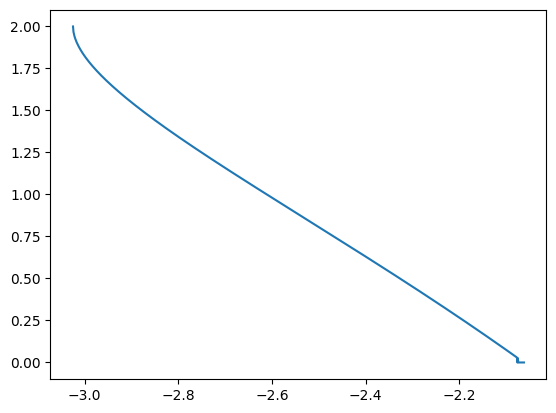

In [29]:
#Let's get the MEST curve for the epileptor
X0 = np.arange(-3.025,-2.062,0.001)
all_the_deltas = f1_find_the_delta(X0)
plt.plot(X0, all_the_deltas)

In [30]:
#Set the drug parameters here
drug = 'valproate'
dose = 200

In [33]:
#Reset of the x0 values on the epileptor 
x0ez=-2.15
x0pz=-2.25
x0num=-2.5

new_x0ez = dose_effect(drug, dose, x0ez, X0, all_the_deltas)
new_x0pz = dose_effect(drug, dose, x0pz, X0, all_the_deltas)
new_x0num = dose_effect(drug, dose, x0num, X0, all_the_deltas)

print(new_x0ez, new_x0pz, new_x0num)

epileptors = models.Epileptor(r=np.array([0.00035]))
epileptors.x0 = new_x0num*np.ones(nb_regions)
epileptors.x0[idx_EZ] = new_x0ez
for id in idx_PZ:
    epileptors.x0[id] = new_x0pz
    new_x0pz -= 0.02

-2.505000000000057 -2.5750000000000495 -2.7370000000000316


In [34]:
#Rerun the Simulation
sim = simulator.Simulator(model=epileptors,
                          initial_conditions=init_cond_reshaped,
                          connectivity=con,
                          coupling=coupl,
                          integrator=heunint,
                          monitors=mons)

sim.configure()

# Run
print("Starting simulation...")
tic = tm.time()
simulation_length = 5000
ttavg = sim.run(simulation_length=simulation_length)
print("Finished simulation.")
print('execute for ' + str(tm.time()-tic))

Starting simulation...
Finished simulation.
execute for 60.50041222572327


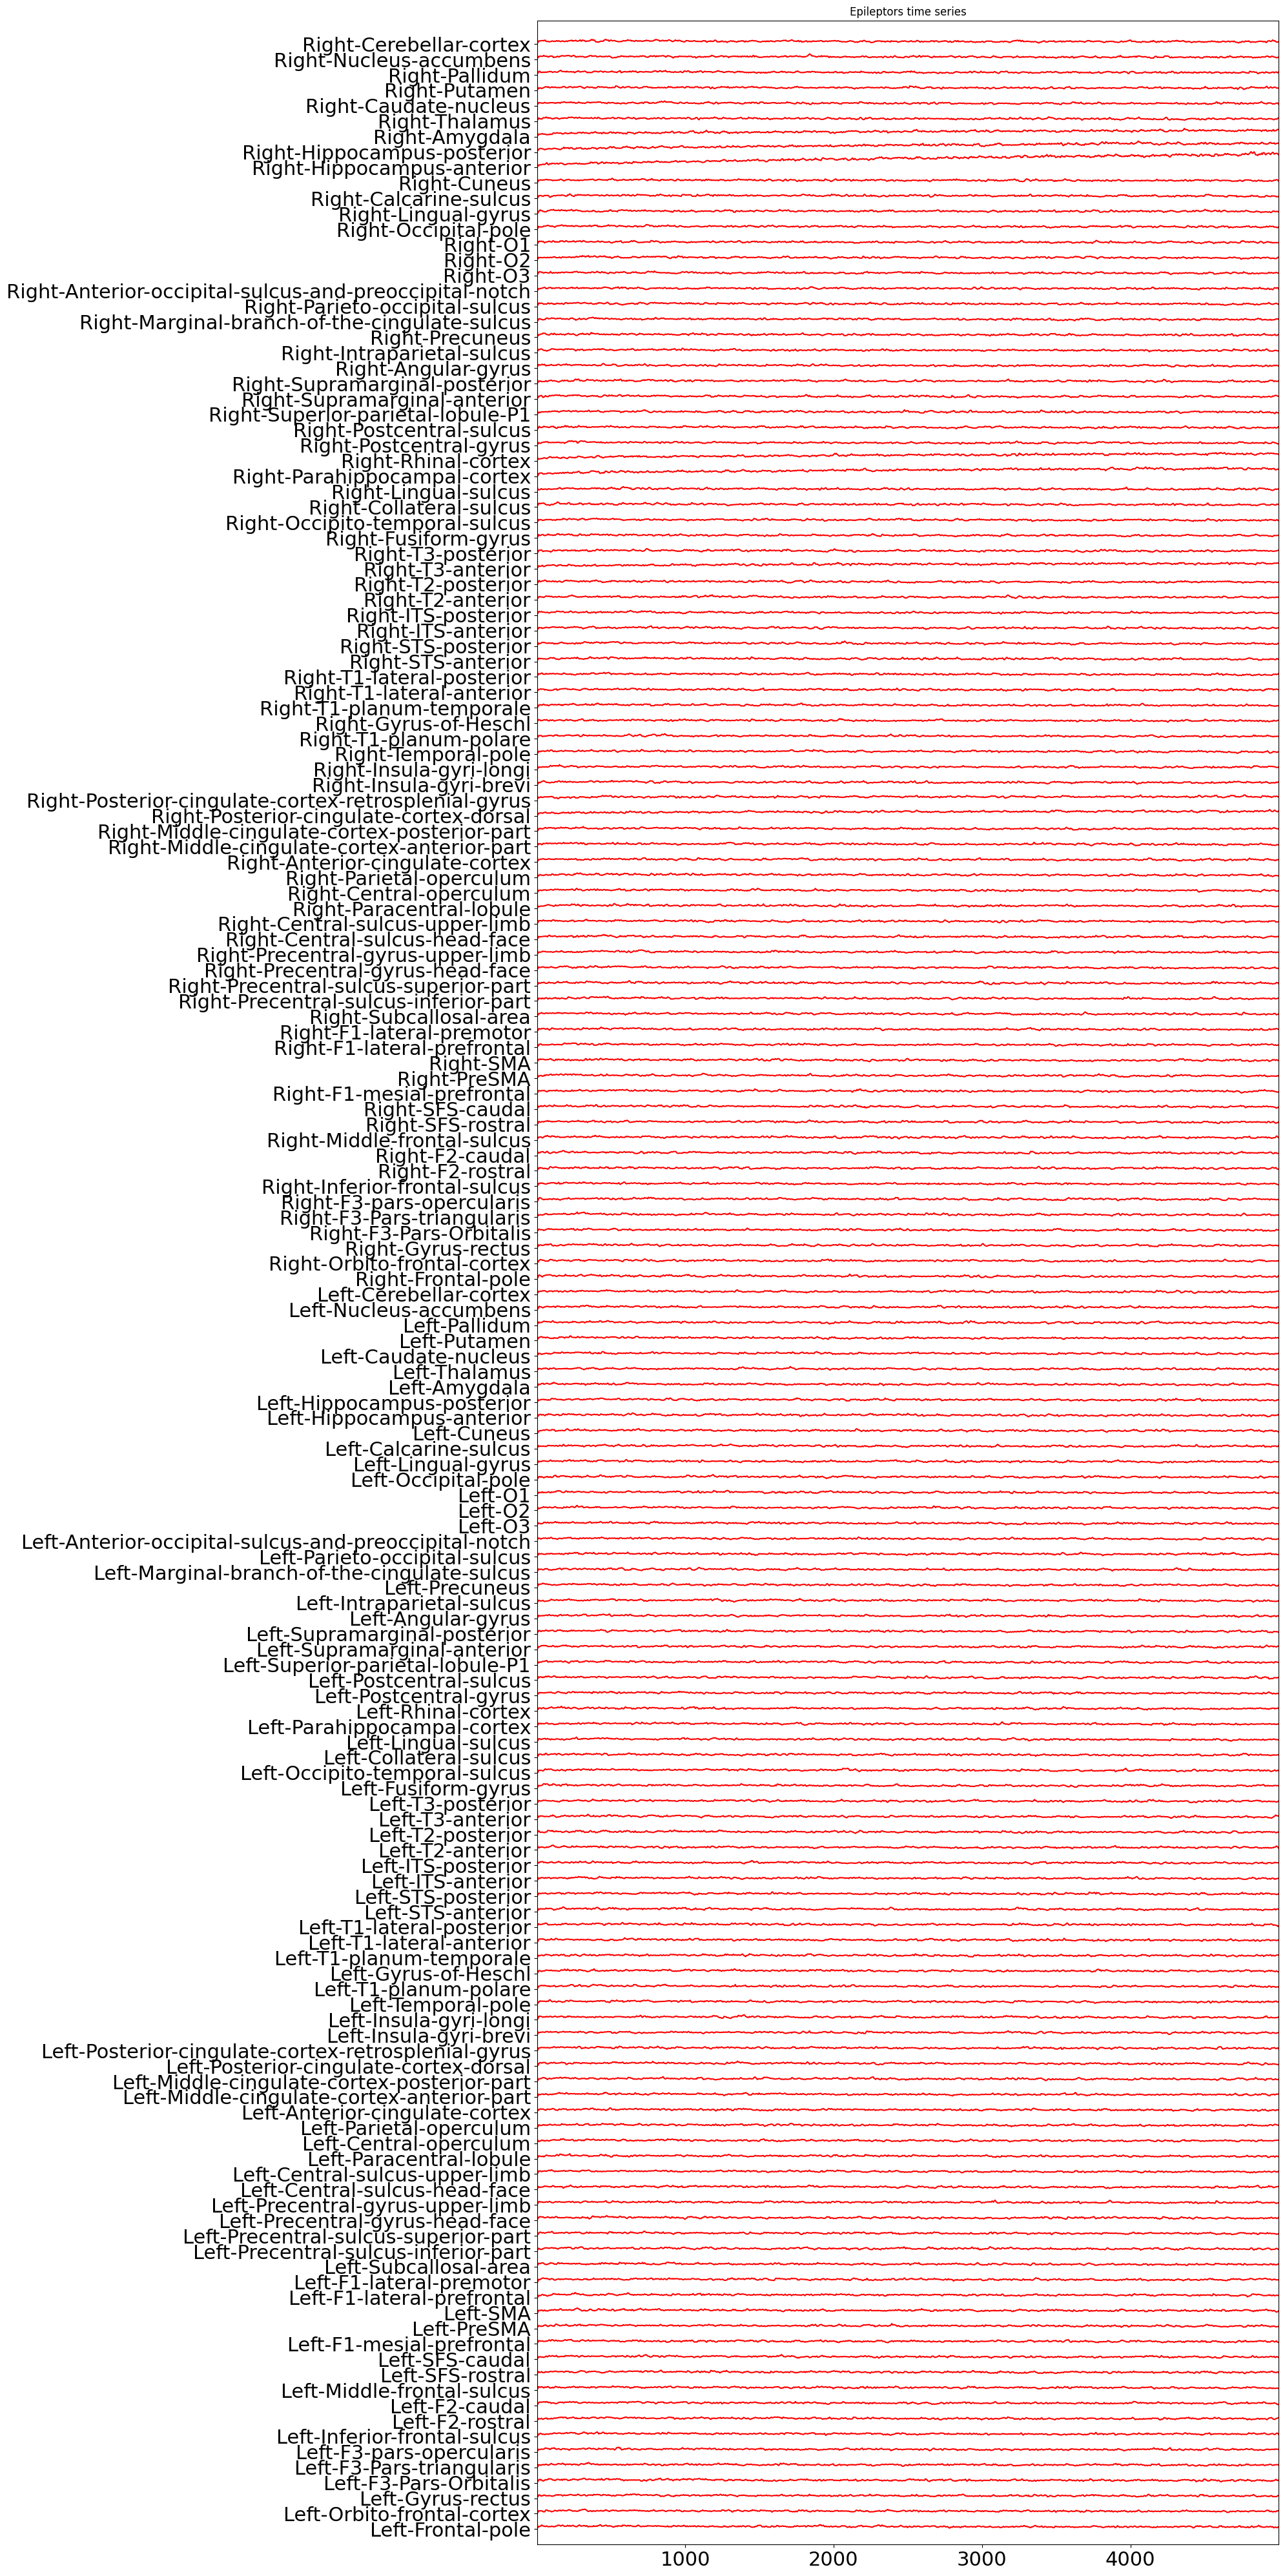

In [35]:
tts = ttavg[0][0]
tavg = ttavg[0][1]
srcSig = tavg[:,0,:,0]
start_idx = 0
end_idx = tavg.shape[0]

srcSig_normal=srcSig/np.ptp(srcSig)
#Plot raw time series
figure= plt.figure(figsize=(20,40))
plt.plot(tts[start_idx:end_idx], srcSig_normal[start_idx:end_idx] + np.r_[:162], 'r')
plt.title("Epileptors time series")
roi = con.region_labels
plt.yticks(np.arange(len(roi)),roi, fontsize=22)

# These should be set manually, since they depend on the model parameters
plt.xticks(fontsize=22)
plt.ylim([-1,len(roi)+0.5])
plt.xlim([tts[start_idx],tts[end_idx-1]])
plt.tight_layout()
plt.show()

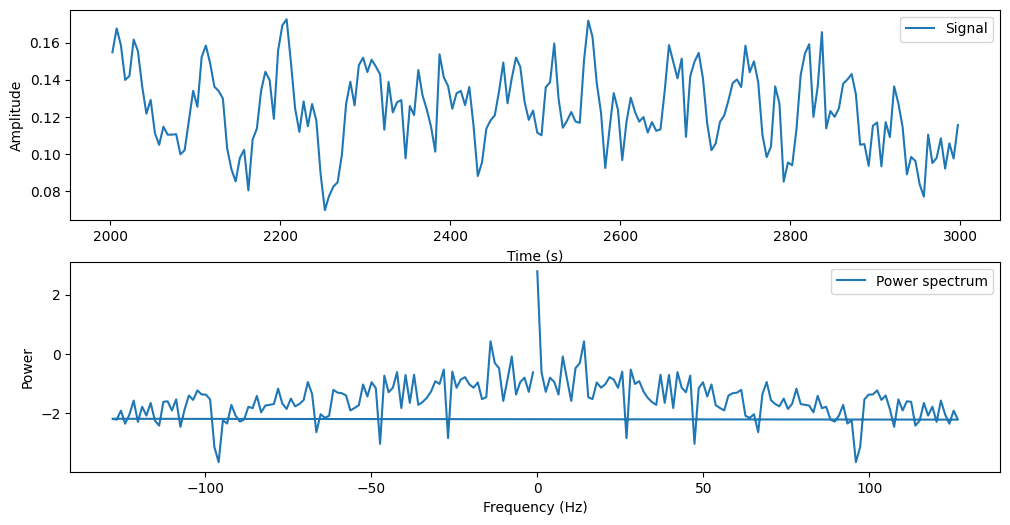

In [36]:
# Compute the FFT and the power spectrum
X = np.fft.fft(srcSig[400:600,161]) # FFT array
P = np.abs(X)**2 # Power spectrum array
f = np.fft.fftfreq(len(srcSig[400:600,161]), 1/256) # Frequency array

# Shift the spectrum and the frequencies
#X = np.fft.fftshift(X) # Shifted FFT array
#P = np.fft.fftshift(P) # Shifted power spectrum array
#f = np.fft.fftshift(f) # Shifted frequency array

P = np.log10(P)

# Plot the signal and the spectrum
plt.figure(figsize=(12,6))
plt.subplot(211)
plt.plot(tts[400:600], srcSig[400:600,161], label='Signal')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.legend()
plt.subplot(212)
plt.plot(f, P, label='Power spectrum')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Power')
#plt.xlim(0, 40) # Zoom in to the relevant frequency range
plt.legend()
plt.show()

In [37]:
max(P)

2.789873255124025

## Simulation with stimulus

Stimuli applied from the SEEG electrode


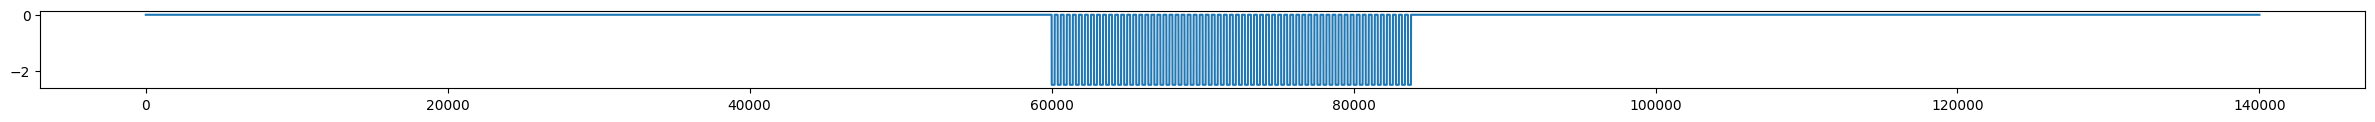

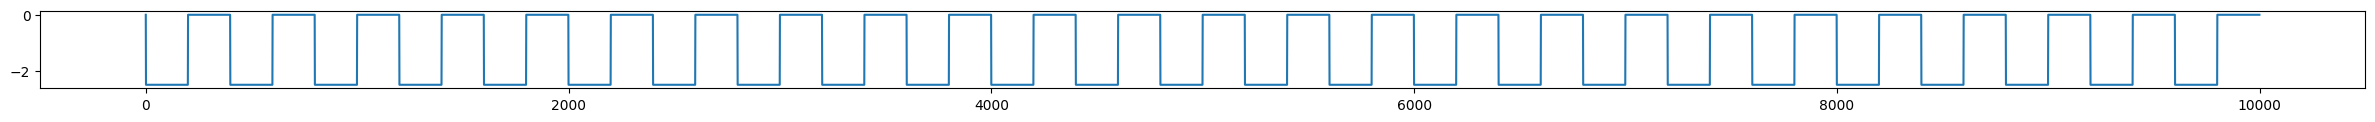

In [16]:
dt = 0.05
onset = 3000 # ms
stim_length = onset + 1200 # stimulation length (including onset) ms
simulation_length = 7000 # ms
freq = 50/1000 # frequency converted to 1/ms
T = 1/freq # pulse repetition period [ms]
tau = 10 # pulse width [ms]
I = 2.5 # intensity [mA]

# Temporal stimulation pattern
class vector1D(equations.DiscreteEquation):
    equation = equations.Final(default="emp")
eqn_t = vector1D()
parameters = {'T': T, 'tau': tau, 'amp': I, 'onset': onset}
pulse1, _ = equations.PulseTrain(parameters=parameters).get_series_data(max_range=stim_length, step=dt)
pulse1_ts = [p[1] for p in pulse1]
parameters = {'T': T, 'tau': tau, 'amp': I, 'onset': onset + tau}
pulse2, _ = equations.PulseTrain(parameters=parameters).get_series_data(max_range=stim_length, step=dt)
pulse2_ts = [p[1] for p in pulse2]
pulse_ts = -np.asarray(pulse1_ts) #- np.asarray(pulse2_ts)
stimulus_ts = np.hstack((pulse_ts[:-1], np.zeros(int(np.ceil((simulation_length - stim_length) / dt)))))
eqn_t.parameters['emp'] = np.copy(stimulus_ts)

print("Stimuli applied from the SEEG electrode")
plt.figure(figsize=(30, 1))
plt.plot(stimulus_ts)
plt.figure(figsize=(30, 1))
plt.plot(stimulus_ts[60000:70000])
plt.show()

In [17]:
# Spatial stimulation pattern (via weights accross the network nodes)
stim_weight = 3
stim_weights = np.zeros((nb_regions))
stim_weights[idx_EZ] = np.array([stim_weight])
stimulus = patterns.StimuliRegion(temporal=eqn_t,
                                  connectivity=con,
                                  weight=stim_weights)
stimulus.configure_space()
stimulus.configure_time(np.arange(0., np.size(stimulus_ts), 1))

In [28]:
x0ez=-2.1
x0pz=-2.12
x0num=-2.4

#Here I set the x0 emulating a temporal sclerosis, which is worse in in the anterior right hippocampus but also made 
#damage to nearby areas, as showed in common MRI findings (https://radiopaedia.org/articles/1664)
EZ = ['Right-Hippocampus-anterior']
PZ = ['Right-Hippocampus-posterior', 'Right-Parahippocampal-cortex', 'Right-Rhinal-cortex', 'Right-Amygdala', 'Right-T3-anterior', 
      'Right-Posterior-cingulate-cortex-dorsal', 'Right-Posterior-cingulate-cortex-retrosplenial-gyrus']
idx_EZ = np.where(roi == EZ)
idx_PZ = [np.where(roi == pz) for pz in PZ]

epileptors = models.Epileptor(r=np.array([0.00035]))
epileptors.x0 = x0num*np.ones(nb_regions)
epileptors.x0[idx_EZ] = x0ez
for id in idx_PZ:
    epileptors.x0[id] = x0pz
    x0pz -= 0.02

# Simulator
sim = simulator.Simulator(model=epileptors,
                          stimulus=stimulus,
                          initial_conditions=init_cond_reshaped,
                          connectivity=con,
                          coupling=coupl,
                          integrator=heunint,
                          monitors=mons)

sim.configure()

# Run
print("Starting simulation...")
tic = tm.time()
ttavg = sim.run(simulation_length=simulation_length)
print("Finished simulation.")
print('execute for ' + str(tm.time()-tic))

[-1.98742113e+00 -1.87492138e+01  4.05295970e+00 -1.05214059e+00
 -4.95543740e-20 -1.98742113e-01]
Starting simulation...
Finished simulation.
execute for 198.16906213760376


## Applying the MEST 

In [60]:
x0ez=-2.1+(0.37*-2.1)
x0pz=-2.12+(0.37*-2.12)
x0num=-2.4+(0.37*-2.4)

#Here I set the x0 emulating a temporal sclerosis, which is worse in in the anterior right hippocampus but also made 
#damage to nearby areas, as showed in common MRI findings (https://radiopaedia.org/articles/1664)
EZ = ['Right-Hippocampus-anterior']
PZ = ['Right-Hippocampus-posterior', 'Right-Parahippocampal-cortex', 'Right-Rhinal-cortex', 'Right-Amygdala', 'Right-T3-anterior', 
      'Right-Posterior-cingulate-cortex-dorsal', 'Right-Posterior-cingulate-cortex-retrosplenial-gyrus']
idx_EZ = np.where(roi == EZ)
idx_PZ = [np.where(roi == pz) for pz in PZ]

epileptors = models.Epileptor(r=np.array([0.00035]))
epileptors.x0 = x0num*np.ones(nb_regions)
epileptors.x0[idx_EZ] = x0ez
for id in idx_PZ:
    epileptors.x0[id] = x0pz
    x0pz -= 0.02

# Initial conditions
init_cond = np.array([-1.98742113e+00 , -1.87492138e+01, 4.0529597e+00, -1.05214059e+00, -4.95543740e-20, -1.98742113e-01])
print(init_cond)
init_cond_reshaped = np.repeat(init_cond, nb_regions).reshape((1, len(init_cond), nb_regions, 1))

#Integrator
heunint = integrators.HeunDeterministic(dt=0.05)

# Simulator
sim = simulator.Simulator(model=epileptors,
                          stimulus=stimulus,
                          initial_conditions=init_cond_reshaped,
                          connectivity=con,
                          coupling=coupl,
                          integrator=heunint,
                          monitors=mons)

sim.configure()

# Run
print("Starting simulation...")
tic = tm.time()
ttavg = sim.run(simulation_length=simulation_length)
print("Finished simulation.")
print('execute for ' + str(tm.time()-tic))

[-1.98742113e+00 -1.87492138e+01  4.05295970e+00 -1.05214059e+00
 -4.95543740e-20 -1.98742113e-01]
Starting simulation...
Finished simulation.
execute for 125.53569149971008


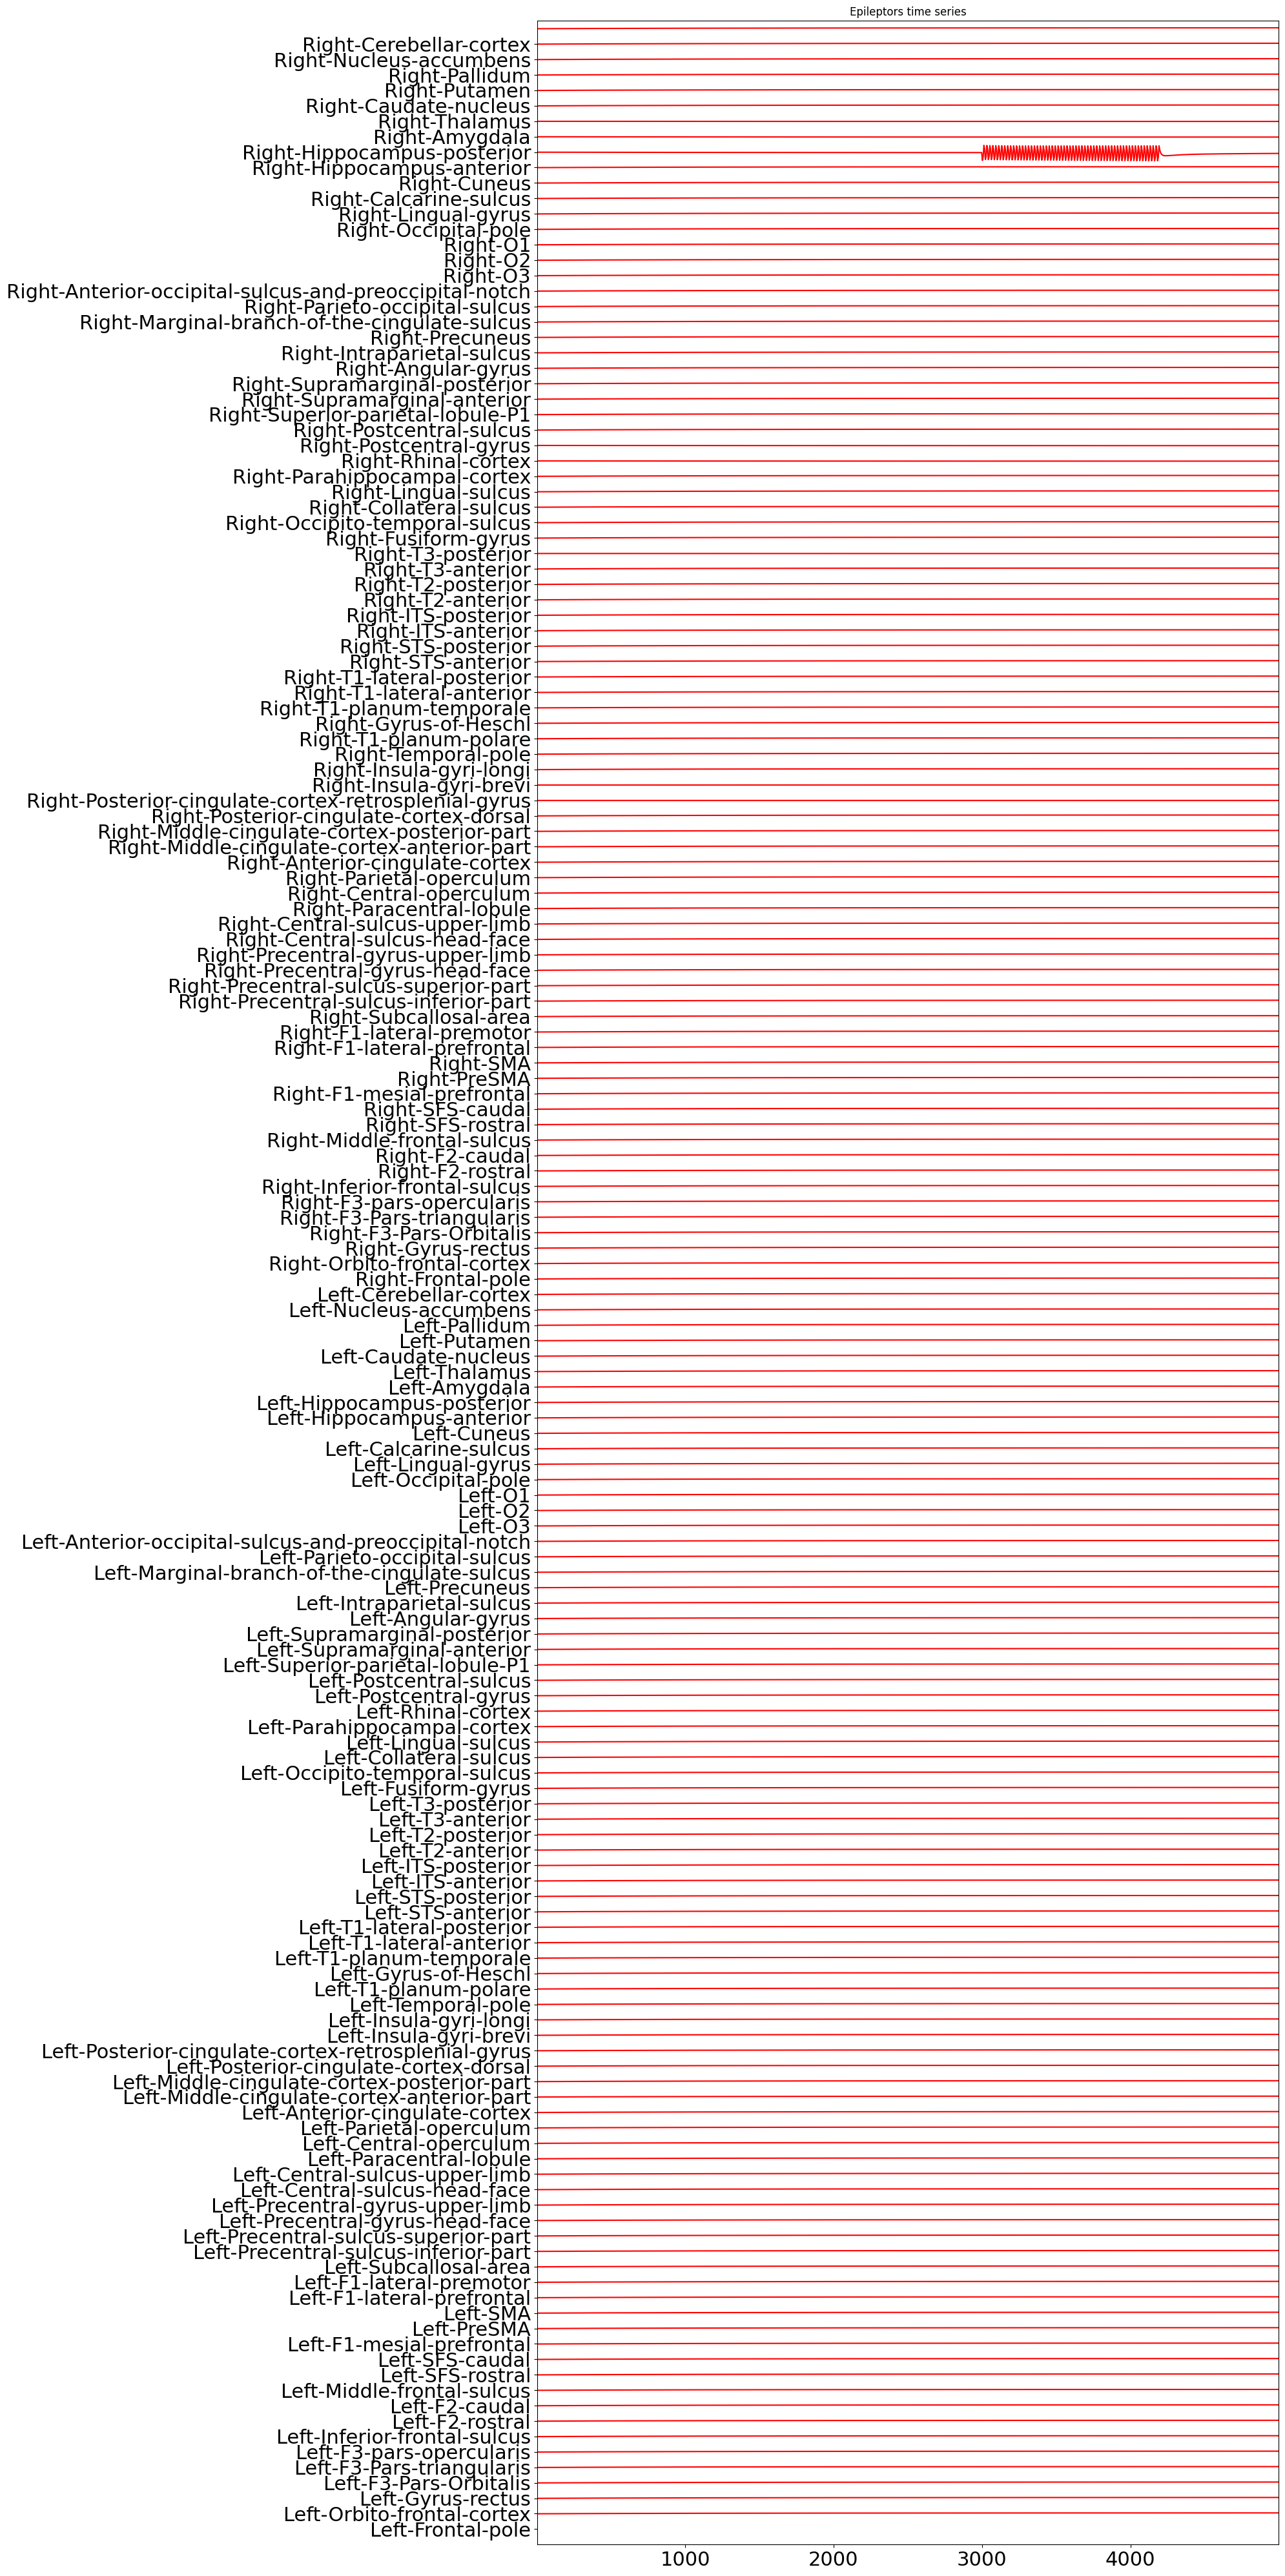

In [61]:
tts = ttavg[0][0]
tavg = ttavg[0][1]
srcSig = tavg[:,0,:,0]
start_idx = 0
end_idx = tavg.shape[0]

srcSig_normal=srcSig/np.ptp(srcSig)
#Plot raw time series
figure= plt.figure(figsize=(20,40))
plt.plot(tts[start_idx:end_idx], srcSig_normal[start_idx:end_idx] + np.r_[:162], 'r')
plt.title("Epileptors time series")
roi = con.region_labels
plt.yticks(np.arange(len(roi)),roi, fontsize=22)

# These should be set manually, since they depend on the model parameters
plt.xticks(fontsize=22)
plt.ylim([-1,len(roi)+0.5])
plt.xlim([tts[start_idx],tts[end_idx-1]])
plt.tight_layout()
plt.show()